In [ ]:
# load binary file
import numpy as np
from scipy.ndimage import filters
from scipy.ndimage import gaussian_filter
import scipy.sparse as sparse
import time
import matplotlib.pyplot as plt
import math
import scipy.io as sio
from matplotlib.colors import hsv_to_rgb
%matplotlib inline

def tic():
    return(time.time())
def toc(t0):
    return(time.time()-t0)

ops0 = sio.loadmat('/media/carsen/DATA1/2P/F/M150329_MP009/2015-04-29/2_4_5_6/regops_M150329_MP009_2015-04-29.mat')

In [ ]:
ops1 = ops0['ops1']

print(ops1[0])

In [ ]:
ops = {
        'reg_file': '/media/carsen/SSD/BIN/M150329_MP009_2015-04-29_2_4_5_6_plane1.bin',
        'Ly': 499,
        'Lx': 494,
        'ny': 512,
        'nx': 512,
        'navg_frames_svd': 5000,
        'nsvd_for_roi': 1000,
        'ratio_neuropil': 6,
        'tile_factor': 1,
        'diameter': 12,
        'threshold_scaling': 1,
        'Vcorr': [],
        'yrange': np.arange(7,506),
        'xrange': np.arange(9,503),
        'allow_overlap': False,
        'inner_neuropil_radius': 2, 
        'outer_neuropil_radius': np.inf, 
        'min_neuropil_pixels': 350, 
        'ratio_neuropil_to_cell': 4,
        'nframes': 153187.0
    }
nframes = ops['nframes']

nt0 = np.ceil(nframes / ops['navg_frames_svd']);
nt0 = int(nt0)
print(nt0)
nimgbatch = nt0 * int(np.floor(2000/nt0));
print(nimgbatch)

In [ ]:
# load and bin data

mov = np.zeros((ops['navg_frames_svd'], ops['Ly'], ops['Lx']), np.float32)

Ly = ops['Ly']
Lx = ops['Lx']
ny = ops['ny']
nx = ops['nx']

reg_file = open(ops['reg_file'], 'rb')
nimgbatch = int(nimgbatch)
block_size = ny*nx*nimgbatch*2
ix = 0
data = 1 
while data is not None:
    buff = reg_file.read(block_size)
    data = np.frombuffer(buff, dtype=np.int16, offset=0)
    nimgd = int(np.floor(data.size / (ny*nx)))
    if nimgd == 0:
        break
    data = np.reshape(data.astype(np.float32), (ny,nx,nimgd), order='F')
    data = np.transpose(data, (2,0,1))
    # subtract mean of batch
    data = data - data.mean(axis=0)
    # bin data
    if nimgd < nimgbatch:
        nmax = int(np.floor(nimgd / nt0) * nt0)
        data = data[:nmax,:,:]
    dbin = np.reshape(data, (nt0,-1,ny,nx))
    dbin = np.squeeze(dbin.mean(axis=0))
    print(dbin.shape)
    inds = ix + np.arange(0,dbin.shape[0])
    # crop into valid area
    mov[inds,:,:] = dbin[:, ops['yrange'][0]:ops['yrange'][-1]+1, ops['xrange'][0]:ops['xrange'][-1]+1]
    ix += dbin.shape[0]
        
reg_file.close()
mov = np.reshape(mov, (mov.shape[0],Ly*Lx))

In [ ]:
mov = np.reshape(mov, (mov.shape[0],Ly*Lx))

In [ ]:
### take SVDs of data
print(mov.shape)
# compute noise variance across frames (assumes slow signal)
sdmov = np.mean(np.diff(mov)**2)**.5
sdmov = max(1e-10,sdmov)
# normalize pixels by noise variance
mov = mov / sdmov

In [ ]:
import celldetect
import imp
imp.reload(celldetect)
S = celldetect.getNeuropilBasis(ops, Ly, Lx)

In [ ]:
# compute covariance of binned frames
cov = (mov @ np.transpose(mov)) / mov.shape[1]

nsvd_for_roi = min(ops['nsvd_for_roi'], cov.shape[0]-2)
# compute svd of covariance
t0=tic()
u, s, v = np.linalg.svd(cov)
print(toc(t0))
u = u[:, :nsvd_for_roi]
U = u.transpose() @ mov

## we will return U, sdmov
nsvd = U.shape[0]

# compute covariance of neuropil masks with spatial masks
StU = S @ U.transpose()
StS = S @ S.transpose()

U = np.reshape(U, (nsvd,Ly,Lx))

In [ ]:
#from matplotlib.colors import hsv_to_rgb
def drawClusters(r,mPix,mLam,Ly,Lx):
    ncells = mPix.shape[1]
    r=np.random.random((ncells,))
    iclust = -1*np.ones((Ly,Lx),np.int32)
    Lam = np.zeros((Ly,Lx))
    H = np.zeros((Ly,Lx,1))
    for n in range(ncells):
        goodi   = np.array((mPix[:,n]>=0).nonzero()).astype(np.int32)
        goodi   = goodi.flatten()
        n0      = n*np.ones(goodi.shape,np.int32)
        lam     = mLam[goodi,n0]
        ipix    = mPix[mPix[:,n]>=0,n].astype(np.int32)
        if ipix is not None:
            ypix,xpix = np.unravel_index(ipix, (Ly,Lx))
            isingle = Lam[ypix,xpix]+1e-4 < lam
            ypix = ypix[isingle]
            xpix = xpix[isingle]
            Lam[ypix,xpix] = lam[isingle]
            iclust[ypix,xpix] = n*np.ones(ypix.shape)
            H[ypix,xpix,0] = r[n]*np.ones(ypix.shape)
        
    S  = np.ones((Ly,Lx,1))
    V  = np.maximum(0, np.minimum(1, 0.75 * Lam / Lam[Lam>1e-10].mean()))
    V  = np.expand_dims(V,axis=2)
    hsv = np.concatenate((H,S,V),axis=2)
    rgb = hsv_to_rgb(hsv)
    plt.figure(figsize=(10,10))
    plt.imshow(rgb[:150,:150])
    plt.show()
        

In [ ]:
d0 = ops['diameter']
sig = np.ceil(d0 / 4) # smoothing constant

# make array of radii values of size (2*d0+1,2*d0+1)
rs,dy,dx     = celldetect.circleMask(2*d0)
rsmall,dy,dx = celldetect.circleMask(d0)

ncell = int(1e4)
mPix = -1*np.ones((dx.size, ncell), np.int32)
mLam = np.zeros((dx.size, ncell), np.float32)

it = 0

ncells = 0
r = np.random.random((ncell,))

L = sparse.lil_matrix((1,Ly*Lx), dtype=np.float32)
nsvd = U.shape[0]
nbasis = S.shape[0]
LtU = np.zeros((0,nsvd), np.float32)
LtS = np.zeros((0,nbasis), np.float32)

# regress maps onto basis functions and subtract neuropil contribution
# U = Ucell + neu'*S'
# neu = inv(S'*S) * (S'*U')

neu = np.linalg.solve(StS, StU)
Ucell = U - np.reshape(neu.transpose() @ S, U.shape)


In [ ]:
def sub2ind(array_shape, rows, cols):
    inds = rows * array_shape[1] + cols
    return inds

err = (Ucell**2).mean()
print(err)
it = 0
while it<2:
    # smooth residual
    t0 = tic()
    us = gaussian_filter(Ucell, [0., sig, sig],  mode='wrap')
    
    # compute log variance at each location
    V = (us**2).mean(axis=0)
    um = (Ucell**2).mean(axis=0)
    um = gaussian_filter(um, [sig, sig],  mode='wrap')
    V  = V / um
    
    if it==0:
        # perform morphological opening on V to normalize brightness
        vrem   = celldetect.morphOpen(V, rs<=d0)
        V      = V - vrem
        # find indices of all maxima in +/- 1 range
        # use the median of these peaks to decide stopping criterion
        maxV   = filters.maximum_filter(V, footprint= rs<=1)
        imax   = V > (maxV - 1e-10)
        peaks  = V[imax]
        thres  = ops['threshold_scaling'] * np.median(peaks[peaks>1e-4])
        ops['Vcorr'] = V
    else:
        V = V - vrem
        # in case this exceeds original value
        V = np.minimum(V, ops['Vcorr'])
    
    plt.imshow(V[:150,:150],vmin=0,vmax=0.005)
    plt.show()
        
    # find local maxima in a +/- d0 neighborhood
    i,j  = celldetect.localMax(V, rs<=d0, thres)
    if i.size==0:
        break
    
    # svd values of cell peaks
    new_codes = us[:,i,j]
    new_codes = new_codes / np.sum(new_codes**2, axis=0)**0.5
    
    for n in range(ncells, ncells+new_codes.shape[1]):
        ypix, xpix, goodi = celldetect.localRegion(i[n-ncells],j[n-ncells],dy,dx,Ly,Lx)
        # weights of svds surrounding max projected onto peak weights
        usub = Ucell[:, ypix, xpix]
        lam = np.maximum(0, new_codes[:,n-ncells].transpose() @ usub)
        lam[lam<lam.max()/5] = 0
        ipix = sub2ind((Ly,Lx), ypix, xpix)
        n0 = n*np.ones((goodi.sum(),),np.int32)
        mPix[goodi,n0] = ipix
        #print((mPix[:,n]>0).sum())
        mLam[goodi,n0] = lam
        # get connected region
        mLam[:,n] = celldetect.connectedRegion(mLam[:,n], rsmall, d0)
        mLam[:,n] = mLam[:,n] / np.sum(mLam[:,n]**2)**0.5
        # save lam in L, LtU, and LtS
        lam  = mLam[goodi,n]
        lam0 = np.zeros((1,Ly*Lx),np.float32)
        lam0[0,ipix] = lam
        if n>0:
            L = sparse.vstack([L, lam0])
        else:
            L[0,:] = lam0
        lam = np.expand_dims(lam,axis=0)
        LtU = np.append(LtU, lam @ np.resize(U[:,ypix,xpix], (nsvd,ypix.size)).transpose(), axis=0)
        LtS = np.append(LtS, lam @ S[:,ipix].transpose(), axis=0)
    
    ncells += new_codes.shape[1]

    
    # regression with neuropil
    L = sparse.csr_matrix(L)
    LtL = (L @ L.transpose()).toarray()
    cellcode = np.concatenate((LtL,LtS), axis=1)
    neucode  = np.concatenate((LtS.transpose(),StS), axis=1)
    codes = np.concatenate((cellcode, neucode), axis=0)
    Ucode = np.concatenate((LtU, StU),axis=0)
    codes = np.linalg.solve(codes + 1e-3*np.eye((codes.shape[0])), Ucode)
    neu   = codes[ncells:,:]
    codes = codes[:ncells,:]

    Ucell = U - np.resize(neu.transpose() @ S, U.shape) - np.resize(codes.transpose() @ L, U.shape)
    
    # reestimate masks
    L = sparse.lil_matrix((1,Ly*Lx),dtype=np.float32)
    #L = sparse.csr_matrix((Ly*Lx,ncells), dtype=np.float32)
    for n in range(0,ncells):
        goodi   = np.array((mPix[:,n]>=0).nonzero()).astype(np.int32)
        goodi   = goodi.flatten()
        n0      = n*np.ones(goodi.shape,np.int32)
        ipix    = mPix[goodi,n0].astype(np.int32)
        ypix,xpix = np.unravel_index(ipix.astype(np.int32), (Ly,Lx))
        usub    = (np.resize(Ucell[:,ypix,xpix],(nsvd,goodi.size)) 
                 + np.expand_dims(codes[n,:],axis=-1) @ np.expand_dims(mLam[goodi,n0],axis=0))
           
        lam = np.maximum(0, codes[n,:] @ usub)
        lam[lam<lam.max()/5] = 0
        mLam[goodi,n0] = lam
        mLam[:,n]  = celldetect.connectedRegion(mLam[:,n], rsmall, d0)
        mLam[:,n]  = mLam[:,n] / np.sum(mLam[:,n]**2)**0.5
        # save lam in L, LtU, and LtS
        lam = mLam[goodi,n]
        lam0 = np.zeros((1,Ly*Lx),np.float32)
        lam0[0,ipix] = lam
        if n>0:
            L = sparse.vstack([L, lam0])
        else:
            L[0,:] = lam0
        #L[n,:] = lam0
        lam = np.expand_dims(lam,axis=0)
        LtU[n,:]  = lam @ np.resize(U[:,ypix,xpix], (nsvd,ypix.size)).transpose()
        LtS[n,:]  = lam @ S[:,ipix].transpose()
         
        Ucell[:,ypix,xpix] = usub - (usub @ lam.transpose()) @ lam
        
    #plt.imshow(np.sum(Ucell[:,:150,:150]**2, axis=0)**.5)
    #plt.show()
    err = (Ucell**2).mean()
    print(err, toc(t0))
    
    drawClusters(r,mPix,mLam,Ly,Lx)
    
    if it==0:
        Nfirst = i.size
    
    
    
    
    it += 1
    
mLam = mLam[:,:ncells]
mLam = mLam / np.expand_dims(mLam.sum(axis=1),axis=-1)
mPix = mPix[:,:ncells]   

In [ ]:
Ucell = U - np.resize(neu.transpose() @ S, U.shape)
#ypix, xpix, goodi = celldetect.localRegion(i[n-ncells],j[n-ncells],dy,dx,Ly,Lx)

stat = celldetect.getStat(Ly,Lx,d0,mPix,mLam,codes,Ucell)    
stat = celldetect.getOverlaps(stat,Ly,Lx)
stat,cell_pix,cell_masks =celldetect.cellMasks(stat,Ly,Lx,False)
neuropil_masks = celldetect.neuropilMasks(ops,stat,cell_pix)
# add surround neuropil masks to stat
for n in range(ncells):
    stat[n]['ipix_neuropil'] = neuropil_masks[n,:,:].flatten().nonzero();

neuropil_masks = sparse.csc_matrix(np.resize(neuropil_masks,(-1,Ly*Lx)))
cell_masks     = sparse.csc_matrix(np.resize(cell_masks,(-1,Ly*Lx)))

In [ ]:
nimgbatch = 2000
nframes = int(ops['nframes'])
ny = ops['ny']
nx = ops['nx']
ncells = cell_masks.shape[0]
F    = np.zeros((ncells,nframes),np.float32)
Fneu = np.zeros((ncells,nframes),np.float32)

reg_file.close()
reg_file = open(ops['reg_file'], 'rb')
nimgbatch = int(nimgbatch)
block_size = ny*nx*nimgbatch*2
ix = 0
data = 1 
t0 = tic()
while data is not None:
    buff = reg_file.read(block_size)
    data = np.frombuffer(buff, dtype=np.int16, offset=0)
    nimgd = int(np.floor(data.size / (ny*nx)))
    if nimgd == 0:
        break
    data = np.reshape(data.astype(np.float32), (ny,nx,nimgd), order='F')
    data = np.transpose(data,(2,0,1))
    # crop data to valid region
    data = data[:, ops['yrange'][0]:ops['yrange'][-1]+1, ops['xrange'][0]:ops['xrange'][-1]+1]
    # resize data to be Ly*Lx by nimgd
    data = np.resize(data, (nimgd,Ly*Lx)).transpose()
    # compute cell activity
    inds = ix + np.arange(0,data.shape[1])
    F[:,inds]    = cell_masks @ data
    # compute neuropil activity
    Fneu[:,inds] = neuropil_masks @ data
    ix += data.shape[1]
    print(ix, toc(t0))
        
reg_file.close()


In [ ]:
plt.plot(F[503,:6000])

In [ ]:
def removeBadFrames(ops,F,Fneu):
    '''add nan's when bad frames occur (high movement frames) '''
    return F,Fneu

def activityStat(stat,F,Fneu):
    dF = F - 0.7 * Fneu
    sd = F.std(axis=1)
    sdN = Fneu.std(axis=1)
    std_cell = sd / sdN
    skew = np.skew(dF,axis=1)
    for n in range(ncells):
    return stat

In [ ]:
print(stat[2]['radius'])
inner_radius = 2
expanded_cell_pix = ndimage.grey_dilation(cell_pix, (inner_radius,inner_radius))
plt.subplot(121)
plt.imshow(cell_pix[:100,:100])
plt.subplot(122)
plt.imshow(expanded_cell_pix[:100,:100])
plt.show()
print(expanded_cell_pix[:100,:100])

In [ ]:
plt.imshow(cell_pix)

In [ ]:
n+=1
plt.imshow(neuropil_masks[n,:,:])
plt.plot(stat[n]['med'][1],stat[n]['med'][0],'o')
neuropil_masks[n,:,:].sum()

In [ ]:
n = 410
mask = np.zeros((Ly,Lx))
overlap = stat[n]['overlap']
ipix = stat[n]['ipix'][~overlap]
ypix = stat[n]['ypix'][~overlap]
xpix = stat[n]['xpix'][~overlap]
lam  = stat[n]['lam'][~overlap]
lam = lam / lam.sum()
print(lam)
mask[ypix,xpix] = lam
params = utils.fitMVGaus(ypix,xpix,lam,2)
plt.imshow(mask)
plt.plot(params[3][:,1],params[3][:,0])
#plt.plot(ypix[lam>.001],xpix[lam>.001],'.')
mu = params[0]
plt.xlim([mu[1]-10,mu[1]+10])
plt.ylim([mu[0]-10,mu[0]+10])
plt.show()

In [5]:
def boundary(ypix,xpix):
    ''' returns pixels of mask that are on the exterior of the mask '''
    ypix = np.expand_dims(ypix.flatten(),axis=1)
    xpix = np.expand_dims(xpix.flatten(),axis=1)
    npix = ypix.shape[0]
    idist = ((ypix - ypix.transpose())**2 + (xpix - xpix.transpose())**2)
    idist[np.arange(0,npix),np.arange(0,npix)] = 500
    nneigh = (idist==1).sum(axis=1) # number of neighbors of each point
    iext = (nneigh<4).flatten()
    return iext


In [36]:
import numpy as np

stat = np.load('../../data/stat.npy')
stat = stat.item()
ops = np.load('../../data/ops.npy')
iscell = np.load('../../data/iscell.npy')
ncells = iscell.shape[0]
for n in range(0,ncells):
    ypix = stat[n]['ypix'][~stat[n]['overlap']]
    xpix = stat[n]['xpix'][~stat[n]['overlap']]
    iext = boundary(ypix, xpix)
    stat[n]['iext'] = iext
        
ops = ops.item()
ncells = len(stat)-1
Ly = ops['Ly']
Lx = ops['Lx']
iROI = -1 * np.ones((Ly,Lx), dtype=np.int32)
iMask   = -1 * np.ones((2,Ly,Lx), dtype=np.int32)
iExt   = -1 * np.ones((2,Ly,Lx), dtype=np.int32)
Lam  = np.zeros((2,Ly,Lx), np.float32)
LamExt  = np.zeros((2,Ly,Lx), np.float32)
Smask  = np.zeros((2,Ly,Lx), np.float32)
Sext  = np.zeros((2,Ly,Lx), np.float32)
for n in range(ncells):
    ypix = stat[n]['ypix'][~stat[n]['overlap']]
    if ypix is not None:
        lam = stat[n]['lam'][~stat[n]['overlap']] 
        lam = lam / lam.sum()
        xpix = stat[n]['xpix'][~stat[n]['overlap']]
        yext = ypix[stat[n]['iext']]
        xext = xpix[stat[n]['iext']]
        #lamext = stat[n]['lam'][iext]
        #lamext = lamext / lamext.sum()
        iROI[ypix,xpix] = n
        iMask[int(1-iscell[n]),ypix,xpix] = n
        iExt[int(1-iscell[n]),yext,xext] = n
        Lam[int(1-iscell[n]),ypix,xpix] = lam
        Smask[int(1-iscell[n]),ypix,xpix] = 1
        Sext[int(1-iscell[n]),yext,xext] = 1        


In [ ]:
stat[n]['iext'].shape

1.115048885345459


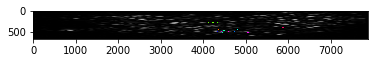

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

%matplotlib inline

vcorr = ops['Vcorr']
mimg = np.zeros((ops['Ly'],ops['Lx']),np.float32)
mimg[ops['yrange'][0]:ops['yrange'][1],
ops['xrange'][0]:ops['xrange'][1]] = vcorr
mimg = mimg - mimg.min()
mimg = mimg / mimg.max()

cols = np.random.random((ncells,))
H = np.zeros((Ly,Lx,1), np.float32)
iM1 = iExt[1,:,:]
H[iM1>=0,0] = cols[iM1[iM1>=0]]
Lam1 = Lam[1,:,:]
#V  = np.maximum(0, np.minimum(1, 0.75 * Lam1/ Lam1[Lam1>1e-10].mean()))
S = np.expand_dims(Sext[1,:,:],axis=2)
V = np.minimum(1, np.expand_dims(mimg,axis=2) + S)
#plt.imshow(Lam[0,:,:],vmin=0,vmax=.015)
t0=tic()
rgb = hsv_to_rgb(np.reshape(np.tile(np.concatenate((H,S,V),axis=2),10),(Ly,Lx*10,3)))
print(toc(t0))

plt.imshow(rgb)

0.11867904663085938


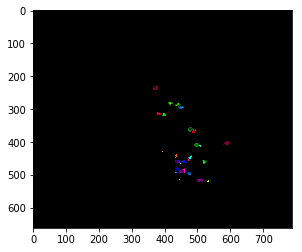

In [37]:
from skimage.color import hsv2rgb
ff = 1
iM1 = iMask[ff,:,:]
H[iM1>=0,0] = cols[iM1[iM1>=0]]
Lam1 = Lam[ff,:,:]
V  = np.maximum(0, np.minimum(1, 0.75 * Lam1/ Lam1[Lam1>1e-10].mean()))
V = np.expand_dims(V,axis=2)
#V = np.minimum(1, np.expand_dims(mimg,axis=2) + S)
S = np.expand_dims(Smask[ff,:,:],axis=2)
#plt.imshow(Lam[0,:,:],vmin=0,vmax=.015)
t0=tic()
rgb = hsv_to_rgb(np.concatenate((H,S,V),axis=2))
print(toc(t0))
plt.imshow(rgb)

In [19]:
rgb1=rgb


In [ ]:
iMask[int(1-iscell[n]),ypix,xpix] = n
iExt[int(1-iscell[n]),yext,xext] = n
Lam[int(1-iscell[n]),ypix,xpix] = lam
Smask[int(1-iscell[n]),ypix,xpix] = 1
Sext[int(1-iscell[n]),yext,xext] = 1 

0.03785848617553711


C:\Users\carse\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice.
C:\Users\carse\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


C:\Users\carse\Anaconda3\lib\site-packages\matplotlib\cm.py:255: RuntimeWarning: invalid value encountered in less
  if norm and xx.max() > 1 or xx.min() < 0:


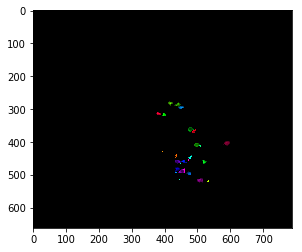

In [38]:
# flip 529
import time
def tic():
    return time.time()
def toc(t0):
    return time.time()-t0

t0=tic()
n = 529
ffrom = int(1-iscell[n])
fto = 1 - ffrom
nin = iMask[ffrom,:,:]==n
iMask[fto,nin] = n
Lam[fto,nin] = Lam[ffrom,nin]
Smask[fto,nin] = 1
niext = iExt[ffrom,:,:]==n
iExt[fto,niext] = n
Sext[fto,niext] = 1

H0   = H[nin]
Lam1 = Lam[fto,nin]
V    = np.maximum(0, np.minimum(1, 0.75 * Lam1/ Lam1[Lam1>1e-10].mean()))
V    = np.expand_dims(V,axis=1)
S    = np.expand_dims(Smask[fto,nin],axis=1)
rgb0[nin,:] = hsv_to_rgb(np.concatenate((H0,S,V),axis=1))

iMask[ffrom,nin] = -1
Lam[ffrom,nin] = 0
Smask[ffrom,nin] = 0
iExt[ffrom,niext] = -1
Sext[ffrom,niext] = 0

H0   = H[nin]
Lam1 = Lam[ffrom,nin]
V    = np.maximum(0, np.minimum(1, 0.75 * Lam1/ Lam1[Lam1>1e-10].mean()))
V    = np.expand_dims(V,axis=1)
S    = np.expand_dims(Smask[ffrom,nin],axis=1)
rgb1[nin,:] = hsv_to_rgb(np.concatenate((H0,S,V),axis=1))

iscell[n] = ~iscell[n]
print(toc(t0))

plt.imshow(rgb1)

In [46]:
npix = len(ypix)
np.resize(np.tile(rgb0[ypix,xpix,:].max(axis=1),3),(npix,3))

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)